In [39]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K
mse = tf.keras.losses.MeanSquaredError()

# from MD_AE_model import *
from model_no_bias import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

import time
import configparser
config = configparser.ConfigParser()
config.read('__system.ini')
system_info = config['system_info']

#============================== CCHANGE THESE VALUES ======================
# data
data_file = '../Data/PIV/PIV4_downsampled_by8.h5'
Ntrain = 1800 # snapshots for training
Ntest = 900 # sanpshots for testingprint()

# path
results_folder = 'MD_10__2022_05_10__14_20_22-linear'
folder = system_info['save_location'] + '/' + results_folder + '/'

## ae configuration
filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
REMOVE_MEAN = file.get('REMOVE_MEAN')[()]
file.close()
print('REMOVE_MEAN',REMOVE_MEAN)

#================================= IMPORT DATA ==========================================================
Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny,Nz]

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train')) # fluctuating velocity if REMOVE_MEAN is true
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test')) # fluctuating velocity if REMOVE_MEAN is true
y_test = np.array(file.get('y_test'))
u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

print("y_test.shape",y_test.shape)

REMOVE_MEAN True
y_test.shape (600, 21, 24, 2)


In [12]:
## get models
md_ae = MD_Autoencoder(Nx=Nx,Nu=Nu,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)

## restore models
filename = folder + 'md_ae_model.h5'
md_ae.compile(optimizer=Adam(learning_rate=0.001),loss=mse)
md_ae.evaluate(u_test,u_test)
md_ae.load_weights(filename)
md_ae.evaluate(u_test,u_test)
print('test_loss: ',mse(u_test,md_ae.predict(u_test)).numpy())

encoder = md_ae.encoder
decoders = []
for name in md_ae.name_decoder:
    decoders.append(md_ae.get_layer(name))

19/19 [==============================] - 4s 212ms/step - loss: 0.7663
test_loss:  0.7420919


In [ ]:
import myplot

SAVE_MODES=False

# modes_test = []
# for i in range(0,10):
#     z = latent_test[:,i]
#     z = np.reshape(z,(-1,1))
#     modes_test.append(decoders[i].predict(z))
# modes_test = np.array(modes_test)
myplot.plot_ae_modes(modes_test,range(10),snapshot=1,savefig=SAVE_MODES,path=folder)

### Plot results

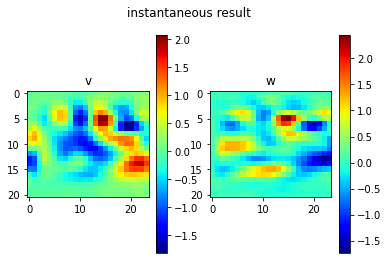

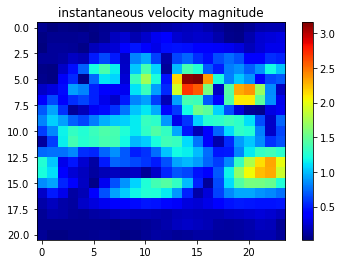

In [31]:
## instantaneous results
time = 200 # which snapshot?
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig1 = ax1.imshow(y_test[time,:,:,0],'jet')
ax1.set_title('v')
fig.colorbar(fig1,ax=ax1)

fig2 = ax2.imshow(y_test[time,:,:,1],'jet')
ax2.set_title('w')
fig.colorbar(fig2,ax=ax2)
plt.suptitle("instantaneous result")
plt.show()

V_test = ((y_test[:,:,:,0]**2)+(y_test[:,:,:,1]**2))**(0.5)
fig = plt.figure()
plt.imshow(V_test[time,:,:],'jet')
plt.colorbar()
plt.title('instantaneous velocity magnitude')
plt.show()

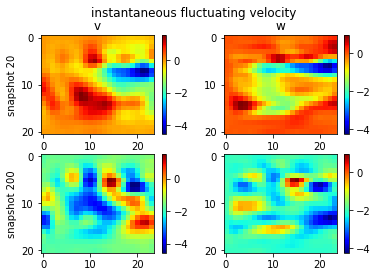

In [32]:
time = 20 # which snapshot?
fig, ax = plt.subplots(2,2)
fig.suptitle('instantaneous fluctuating velocity')
fig1 = ax[0,0].imshow(y_test[time,:,:,0],'jet')
ax[0,0].set_title('v')
ax[0,0].set_ylabel('snapshot %i'%(time))
fig.colorbar(fig1,ax=ax[0,0])
fig2 = ax[0,1].imshow(y_test[time,:,:,1],'jet')
ax[0,1].set_title('w')
fig.colorbar(fig2,ax=ax[0,1])

time = 200 # which snapshot?
fig3 = ax[1,0].imshow(y_test[time,:,:,0],'jet')
fig.colorbar(fig1,ax=ax[1,0])
ax[1,0].set_ylabel('snapshot %i'%(time))
fig4 = ax[1,1].imshow(y_test[time,:,:,1],'jet')
fig.colorbar(fig2,ax=ax[1,1])

In [ ]:
## latent space line plot
print(latent_test.shape)
plt.figure()
for z in range(latent_dim):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.xlim([0,600])
plt.legend()
plt.show()

In [ ]:
# fft of latent space signal
signal_in = latent_test[:,3] # which one
signal_fft = np.fft.fft(signal_in)
signal_fft_power = np.abs(signal_fft)/signal_in.size
signal_freq = np.fft.fftfreq(signal_in.size)
signal_freq = signal_freq/dt
# print(signal_freq.size/2)
plt.figure()
plt.plot(signal_freq[:int(signal_freq.size/2)],signal_fft_power[:int(signal_freq.size/2)])
plt.ylim(bottom=0)
plt.yticks([0])
plt.xlim(left=0)
loc,label = plt.xticks()
loc = np.r_[0:max(loc):25]
plt.xticks(loc)
plt.show()

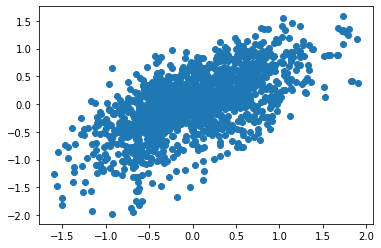

In [30]:
plt.figure()
plt.scatter(latent_train[:,67],latent_train[:,16])
plt.show()

Text(0.5, 0.98, 'u and v autoencoder modes')

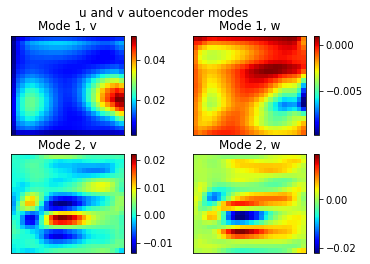

In [33]:
## plot time-averaged autoencoder mode
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(np.mean(modes_test,axis=1)[0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(np.mean(modes_test,axis=1)[0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(np.mean(modes_test,axis=1)[1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(np.mean(modes_test,axis=1)[1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("u and v autoencoder modes")

In [40]:
print(modes_test.shape)
modes_test_mean = np.mean(modes_test,axis=1)
print(modes_test_mean.shape)
mode_test = np.transpose(modes_test,[1,0,2,3,4])
print(mode_test.shape)
mode_test = mode_test-modes_test_mean
print(mode_test.shape)
# mode_test = np.transpose(mode_test,[1,0,2,3,4])

(10, 600, 21, 24, 2)
(10, 21, 24, 2)
(600, 10, 21, 24, 2)
(600, 10, 21, 24, 2)


(10, 604800)
[ 7  1  4 10  3  9  5  6  2  8]
(10,)
[ 4 10  7  8  5  1  9  3  6  2]


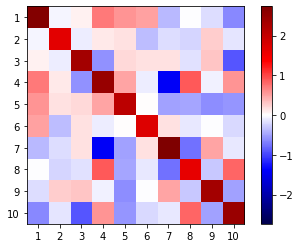

In [41]:
flatmodes = np.reshape(modes_test[:,:,:,:,:],[latent_dim,-1])
print(flatmodes.shape)
# a = latent_test - np.mean(latent_test,axis=0)
# cov = (a.T@a)/599
cov = latent_test.T@latent_test/600
# cov = np.cov(latent_test.T)
# cov = np.cov(flatmodes)
# cov = np.corrcoef(latent_test.T)
# cov = np.corrcoef(flatmodes)
# print(cov)
vmax = np.max(cov)
plt.figure()
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
# plt.savefig(folder+'var-cov-latent.png')
sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_var)

covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
sort_idx = np.argsort(covar_sum)
rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(covar_sum.shape)
print(rank_cov)



In [42]:
det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 
# det=1: completely uncorrelated 
# det=0: completely correlated

determinant of corr matrix:  0.13278635295793237


In [ ]:
## plot instantaneous autoencoder modes

# test_mean = np.mean(u_test,0)
# # # test_mean = np.zeros_like(test_mean)
# print(test_mean.shape)
# mode_test = np.transpose(modes_test,[1,0,2,3,4])
# print(mode_test[:,0,:,:,:].shape)
# mode_test[:,0,:,:,:] = mode_test[:,0,:,:,:]-test_mean
# mode_test[:,1,:,:,:] = mode_test[:,1,:,:,:]-test_mean
# mode_test = np.transpose(mode_test,[1,0,2,3,4])
# print(mode_test.shape)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(mode_test[time,0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(mode_test[time,0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(mode_test[time,1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(mode_test[time,1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("instantaneous u and v autoencoder modes, remove mean")

### Ranking

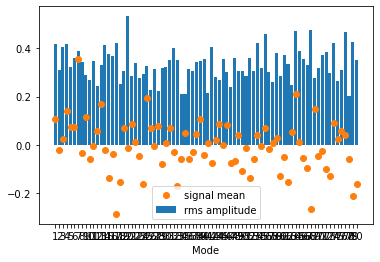

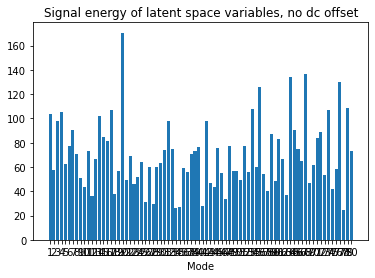

[20 68 64 77 56 79 54 17 74  4  1 14  3 42 32  7 65 72 59 15 71 61 16 52
 48  6 40 45 66 33 31 80 11 39  8 38 22 62 13 67 25 30  5 70 29 55 27 36
 76  2 50 19 49 53 37 46 57 73 24  9 21 51 60 43 69 23 10 44 75 58 18 63
 12 47 26 28 41 35 34 78]


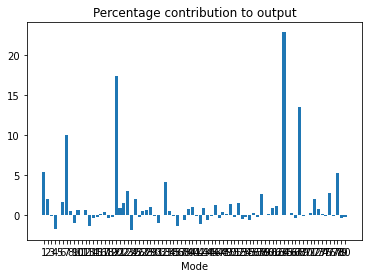

In [4]:
import autoencoder_modes_selection as ranking
SAVE_FIG = False

#========================= RMS amplitude of latent variable =====================
amp_rms,m = ranking.rms_amplitude(latent_test)
plt.figure()
plt.bar(np.arange(latent_dim)+1,amp_rms,label='rms amplitude',zorder=1)
plt.scatter(np.arange(latent_dim)+1,m,label='signal mean',zorder=2)
plt.xticks(np.arange(latent_dim)+1)
plt.legend()
plt.xlabel("Mode")
if SAVE_FIG:
    figname = folder + 'ranking_rms.png'
    plt.savefig(figname)
else:
    plt.show()

#============================ energy spectrum of signal ==========================
signal_energy = ranking.energy_freq(latent_test,remove_mean=True)
fig2 = plt.figure()
plt.bar(np.arange(latent_dim)+1,signal_energy)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
# plt.title("Signal energy of latent space variables")
plt.title("Signal energy of latent space variables, no dc offset")
if SAVE_FIG:
    figname = folder + 'ranking_energy.png'
    plt.savefig(figname)
else:
    plt.show()
sort_idx = np.argsort(signal_energy)
rank_signal = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_signal)

#============================ precentage loss ============================================
per_mode = ranking.percent_output(modes_test,y_test)
fig3 = plt.figure()
plt.bar(np.arange(latent_dim)+1,per_mode*100)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Percentage contribution to output")
if SAVE_FIG:
    figname = folder + 'ranking_percenty.png'
    plt.savefig(figname)
else:
    plt.show()
sort_idx = np.argsort(np.abs(per_mode))
rank_con = np.arange(1,latent_dim+1)[np.flip(sort_idx)]

# #=============================== NED ==============================================
# bins = 10
# NED = ranking.NED(latent_test,bins,act_fct=act_fct)
# fig4 = plt.figure()
# plt.bar(np.arange(latent_dim)+1,NED)
# plt.xticks(np.arange(latent_dim)+1)
# plt.xlabel("Mode")
# plt.title("Normalised entropy difference "+str(bins)+" bins")
# if SAVE_FIG:
#     figname = folder + 'ranking_ned.png'
#     plt.savefig(figname)
# else:
    # plt.show()

In [5]:
# ke
ke = np.sum((modes_test**2),axis=(4,3,2,1))/(2*latent_test.shape[0])
sort_idx = np.argsort(ke)
rank_ke = np.arange(1,latent_dim+1)[np.flip(sort_idx)]


In [ ]:
# energy percentage (Eivazi 2022)
modes_E = np.copy(modes_test)
rank_en = np.zeros(latent_dim,dtype='int')-1

for j in range(latent_dim):
    E_ref = 0
    for i in range(latent_dim):
        if i not in rank_en:
            E = 1-np.mean(np.sum((modes_E[i,:,:,:,:] - u_test)**2,axis=(3,2,1))/np.sum(u_test**2,axis=(3,2,1)))
            if E > E_ref:
                E_ref = E
                rank_en[j] = i
    modes_E = modes_test + modes_E[rank_en[j]]
rank_en += 1

In [8]:
# mse loss
modes_E = np.copy(modes_test)
rank_mse = np.zeros(latent_dim,dtype='int')-1
for j in range(latent_dim):
    E_ref = 0
    for i in range(latent_dim):
        if i not in rank_mse:
            E = 1/mse(u_test,modes_E[i]).numpy()
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = modes_test + modes_E[rank_mse[j]]
rank_mse += 1
print(rank_mse)

2022-05-18 12:21:07.927878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 12:21:07.927906: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 12:21:07.927925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist
2022-05-18 12:21:07.928193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[64 20 68 79  1 77  7  4 17 42 52 13 74 54 15 72 80 56 61 71 65 25 50 31
 14 48 40 22  8 59  5 30 39 11 16 66 23 29 49  3 32 19 69  6 36  9 53 62
 45 27 70 38 60 33 67 46 55 21 76 37 24  2 18 57 43 28 10 73 44 35 51 26
 47 78 75 12 63 41 58 34]


In [25]:
print('contriburion:   ',rank_con) # percentage contribution
print('kinetic energy: ',rank_ke) # kinetic energy
print('signal:         ',rank_signal) # signal
print('lambda_ae:      ',rank_var) # Z.T@Z, diagonal (variance)
print('covariance sum: ',rank_cov) # Z.T@Z antisymmetrix part sum of each row
print('energy eivazi:  ',rank_en) # energy (Eivazi 2022)

contriburion:    [64 20 68  7  1 78 33 23 76 58  2 72 25 24  4  6 22 52 50 13 46 36 62 40
 42 29 31 43  9 61 21 73 39 12 28 10 44 55 38  8 27 34 53 17 48 67 56 79
 18 47 14 71 19 51 66 57 16 80 60 54 15 26 49 74 45 63  3 65 59  5 41 77
 30 35 11 75 32 70 69 37]
kinetic energy:  [17 74 64 14 77 54 56 42 20 52 65 79 71 68 15 40 61 80 50 72 31  4 48  1
  7 62 13 29  8 22 49 66 59 30 16 32 11  3 39 38 36 45 25 46 27  6 18 53
 33  5 60 70 21 24 67 37  9 19 55 57 69 76  2 73 78 10 28 44 51 23 43 26
 75 58 47 35 12 41 34 63]
signal:          [20 68 64 77 56 79 54 17 74  4  1 14  3 42 32  7 65 72 59 15 71 61 16 52
 48  6 40 45 66 33 31 80 11 39  8 38 22 62 13 67 25 30  5 70 29 55 27 36
 76  2 50 19 49 53 37 46 57 73 24  9 21 51 60 43 69 23 10 44 75 58 18 63
 12 47 26 28 41 35 34 78]
lambda_ae:       [20 68 64 77 56 79 54 17 74  4  1 14  3 42 32  7 65 72 59 15 71 61 16 52
 48  6 40 45 66 33 31 80 11 39  8 38 22 62 13 67 25 30  5 70 29 55 27 36
 76  2 50 19 49 53 37 46 57 73 24  9 21 51 60 43 69

NameError: name 'rank_en' is not defined

In [ ]:
print(mse(u_test,modes_test[10-1]).numpy())
print(mse(u_test,modes_test[10-1]+modes_test[7-1]).numpy())
print(mse(u_test,modes_test[10-1]+modes_test[7-1]+modes_test[3-1]).numpy())
print(mse(u_test,modes_test[10-1]+modes_test[7-1]+modes_test[1-1]).numpy())

In [ ]:
rank_i_en = []
modes_E = np.copy(modes_test)
for i in range(latent_dim):
    E = 1-np.mean(np.sum((modes_E[i,:,:,:,:] - y_test)**2,axis=(3,2,1))/np.sum(y_test**2,axis=(3,2,1)))
    rank_i_en.append(E)
sort_idx = np.argsort(rank_i_en)
rank_i_en = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_i_en)